# Import

In [2]:
# pip install datasets

In [ ]:
# pip install transformers[torch]

In [6]:
# pip install optuna

In [1]:
import os
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer, BertForSequenceClassification
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import Trainer, TrainingArguments
from transformers import pipeline
from datasets import concatenate_datasets, load_dataset
from huggingface_hub import hf_hub_download
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datasets
from datasets import Dataset, Value, ClassLabel, Features
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
# os.environ["CUDA_VISIBLE_DEVICES"] = "2"
from transformers import DataCollatorWithPadding
# import optuna
from huggingface_hub import notebook_login
from sklearn.model_selection import StratifiedKFold

# lables value
# 2 = positive
# 1 = neutral
# 0 = negative

# Dataset

In [8]:
notebook_login()

In [2]:
dataset = load_dataset("HFFErica/TBSA_sentiment_round2", data_files={'train': 'train_df_balanced.csv', 'test': 'test_df_imbalanced.csv'})
dataset

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 1209
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1963
    })
})

In [3]:
folds = StratifiedKFold(n_splits=15)
splits = folds.split(np.zeros(dataset["train"].num_rows), dataset["train"]["label"])

for train_idxs, val_idxs in splits:
    dataset = load_dataset("HFFErica/TBSA_sentiment_round2", data_files={'train': 'train_df_balanced.csv', 'test': 'test_df_imbalanced.csv'})
    dataset["test"] = dataset["test"]
    dataset["validation"] = dataset["train"].select(val_idxs)
    dataset["train"] = dataset["train"].select(train_idxs)

In [4]:
features = dataset["train"].features.copy()
features["label"] = ClassLabel(names=['negative', 'neutral', 'positive'])
def adjust_labels(batch):
    batch["label"] = [sentiment  for sentiment  in batch["label"]]
    return batch
label_dataset = dataset.map(adjust_labels, batched=True, features=features)

features = dataset["validation"].features.copy()
features["label"] = ClassLabel(names=['negative', 'neutral', 'positive'])
def adjust_labels(batch):
    batch["label"] = [sentiment  for sentiment  in batch["label"]]
    return batch
label_dataset = dataset.map(adjust_labels, batched=True, features=features)

features = dataset["test"].features.copy()
features["label"] = ClassLabel(names=['negative', 'neutral', 'positive'])
def adjust_labels(batch):
    batch["label"] = [sentiment  for sentiment  in batch["label"]]
    return batch
label_dataset = dataset.map(adjust_labels, batched=True, features=features)

Map:   0%|          | 0/1129 [00:00<?, ? examples/s]

Map:   0%|          | 0/80 [00:00<?, ? examples/s]

In [5]:
label_dataset['train'][1]

{'text': "This is hands down the worst tutorial I have ever played in my entire life (I still can't believe I actually powered through those 3 hours) and ",
 'label': 0}

In [6]:
label_dataset["train"].features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['negative', 'neutral', 'positive'], id=None)}

## Mapping

In [7]:
train_dataset = label_dataset['train']
validation_dataset = label_dataset['validation']
test_dataset = label_dataset['test']


print(train_dataset)
print(validation_dataset)
print(test_dataset)

Dataset({
    features: ['text', 'label'],
    num_rows: 1129
})
Dataset({
    features: ['text', 'label'],
    num_rows: 80
})
Dataset({
    features: ['text', 'label'],
    num_rows: 1963
})


In [8]:
train_dataset = train_dataset.map(lambda examples: {'labels': examples['label']}, batched=True)
validation_dataset = validation_dataset.map(lambda examples: {'labels': examples['label']}, batched=True)
test_dataset = test_dataset.map(lambda examples: {'labels': examples['label']}, batched=True)

Map:   0%|          | 0/1129 [00:00<?, ? examples/s]

Map:   0%|          | 0/80 [00:00<?, ? examples/s]

# Model

In [ ]:
# tokenizer = AutoTokenizer.from_pretrained("mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")
# model = AutoModelForSequenceClassification.from_pretrained("mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")

In [9]:
model_id="cardiffnlp/twitter-roberta-base-sentiment-latest"

# label2id = {"positive": 2, "neutral": 1,"negative":0}
# id2label = {"positive": 2, "neutral": 1,"negative":0}

# 2 = positive
# 1 = neutral
# 0 = negative

model = AutoModelForSequenceClassification.from_pretrained(model_id,
                                                           num_labels=train_dataset.features["label"].num_classes,
                                                          ignore_mismatched_sizes=True)
tokenizer = AutoTokenizer.from_pretrained(model_id)
model.config

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For 

RobertaConfig {
  "_name_or_path": "cardiffnlp/twitter-roberta-base-sentiment-latest",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "negative",
    "1": "neutral",
    "2": "positive"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "negative": 0,
    "neutral": 1,
    "positive": 2
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.44.2",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

In [10]:
MAX_LENGTH = 256

In [11]:
train_dataset = train_dataset.map(lambda e: tokenizer(e['text'], truncation=True, padding='max_length', max_length=MAX_LENGTH), batched=True)
validation_dataset = validation_dataset.map(lambda e: tokenizer(e['text'], truncation=True, padding='max_length', max_length=MAX_LENGTH), batched=True)
test_dataset = test_dataset.map(lambda e: tokenizer(e['text'], truncation=True, padding='max_length', max_length=MAX_LENGTH), batched=True)

Map:   0%|          | 0/1129 [00:00<?, ? examples/s]

Map:   0%|          | 0/80 [00:00<?, ? examples/s]

In [12]:
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
validation_dataset.set_format(type='torch', columns=['input_ids',  'attention_mask', 'labels'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

In [13]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# hyperparameters search

In [29]:
def model_init():
    return AutoModelForSequenceClassification.from_pretrained(model_id, return_dict=True)

In [30]:
from sklearn.metrics import f1_score
# Define a function to compute the F1 score
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    f1 = f1_score(labels, predictions, average='weighted')
    return {"f1": f1}

In [31]:
training_args = TrainingArguments("test",  eval_steps=500, disable_tqdm=True, do_eval=True, evaluation_strategy='steps')
trainer = Trainer(
    args=training_args,
    data_collator=DataCollatorWithPadding(tokenizer),
    train_dataset=train_dataset,
    # eval_dataset=validation_dataset,
    eval_dataset=test_dataset,
    model_init=model_init,
    compute_metrics=compute_metrics,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


ImportError: Using the `Trainer` with `PyTorch` requires `accelerate>=0.21.0`: Please run `pip install transformers[torch]` or `pip install accelerate -U`


In [ ]:
def my_hp_space(trial):
    return {
        "learning_rate": trial.suggest_float("learning_rate", 1e-6, 1e-3, log=True),
        "num_train_epochs": trial.suggest_int("num_train_epochs", 1, 5),
#         "seed": trial.suggest_int("seed", 1, 40),
        "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [8,16, 24, 32, 36, 40, 48,56, 64]),
    }

In [32]:
def hp_space_optuna(trial):
    return {
        "learning_rate": trial.suggest_float("learning_rate", 1e-5, 5e-5, log=True),
        "num_train_epochs": trial.suggest_int("num_train_epochs", 2, 4),
        "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [16, 32, 64]),
    }

In [ ]:
# Conduct hyperparameter search using Optuna, optimizing for the F1 score
best_run = trainer.hyperparameter_search(
    hp_space=hp_space_optuna,
    direction="maximize",  # Maximize the F1 score
    backend="optuna",      # Use Optuna for the search
    n_trials=10            # Number of trials for search
)

print(f"Best run: {best_run}")

In [33]:
best_run = trainer.hyperparameter_search(direction="maximize", hp_space=hp_space_optuna, n_trials=10)
print(f"Best run: {best_run}")

[I 2024-09-12 11:54:25,218] A new study created in memory with name: no-name-6b078c2b-12c0-432c-92c8-677b22c7f902
Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


{'train_runtime': 89.1217, 'train_samples_per_second': 44.164, 'train_steps_per_second': 2.783, 'train_loss': 0.48016646600538687, 'epoch': 4.0}


[I 2024-09-12 11:56:09,950] Trial 0 finished with value: 0.7876070696351614 and parameters: {'learning_rate': 1.5930933719597684e-05, 'num_train_epochs': 4, 'per_device_train_batch_size': 16}. Best is trial 0 with value: 0.7876070696351614.


{'eval_loss': 0.716618537902832, 'eval_f1': 0.7876070696351614, 'eval_runtime': 14.4033, 'eval_samples_per_second': 136.289, 'eval_steps_per_second': 17.079, 'epoch': 4.0}


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


{'train_runtime': 47.2551, 'train_samples_per_second': 41.646, 'train_steps_per_second': 2.624, 'train_loss': 0.6388071736981792, 'epoch': 2.0}


[I 2024-09-12 11:57:12,786] Trial 1 finished with value: 0.7493508873498897 and parameters: {'learning_rate': 1.4862322514631366e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 16}. Best is trial 0 with value: 0.7876070696351614.


{'eval_loss': 0.68345046043396, 'eval_f1': 0.7493508873498897, 'eval_runtime': 14.4005, 'eval_samples_per_second': 136.315, 'eval_steps_per_second': 17.083, 'epoch': 2.0}


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


{'train_runtime': 81.9704, 'train_samples_per_second': 48.017, 'train_steps_per_second': 0.781, 'train_loss': 0.5722629427909851, 'epoch': 4.0}


[I 2024-09-12 11:58:50,115] Trial 2 finished with value: 0.7609566454931175 and parameters: {'learning_rate': 1.6663041178087473e-05, 'num_train_epochs': 4, 'per_device_train_batch_size': 64}. Best is trial 0 with value: 0.7876070696351614.


{'eval_loss': 0.7054505944252014, 'eval_f1': 0.7609566454931175, 'eval_runtime': 14.237, 'eval_samples_per_second': 137.88, 'eval_steps_per_second': 17.279, 'epoch': 4.0}


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


{'train_runtime': 46.811, 'train_samples_per_second': 42.041, 'train_steps_per_second': 2.649, 'train_loss': 0.6426146107335244, 'epoch': 2.0}


[I 2024-09-12 11:59:52,370] Trial 3 finished with value: 0.7785081830420765 and parameters: {'learning_rate': 4.150285666390422e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 16}. Best is trial 0 with value: 0.7876070696351614.


{'eval_loss': 0.6241759061813354, 'eval_f1': 0.7785081830420765, 'eval_runtime': 14.1888, 'eval_samples_per_second': 138.348, 'eval_steps_per_second': 17.338, 'epoch': 2.0}


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


{'train_runtime': 44.8553, 'train_samples_per_second': 43.874, 'train_steps_per_second': 1.382, 'train_loss': 0.6340846400107106, 'epoch': 2.0}


[I 2024-09-12 12:00:52,857] Trial 4 finished with value: 0.7487736409570539 and parameters: {'learning_rate': 2.3872844234091002e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 32}. Best is trial 0 with value: 0.7876070696351614.


{'eval_loss': 0.6801523566246033, 'eval_f1': 0.7487736409570539, 'eval_runtime': 14.5193, 'eval_samples_per_second': 135.2, 'eval_steps_per_second': 16.943, 'epoch': 2.0}


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


{'train_runtime': 46.5796, 'train_samples_per_second': 42.25, 'train_steps_per_second': 1.331, 'train_loss': 0.6335665179837134, 'epoch': 2.0}


[I 2024-09-12 12:01:54,821] Trial 5 finished with value: 0.7464271353722574 and parameters: {'learning_rate': 2.4557100092450037e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 32}. Best is trial 0 with value: 0.7876070696351614.


{'eval_loss': 0.6797289252281189, 'eval_f1': 0.7464271353722574, 'eval_runtime': 14.2411, 'eval_samples_per_second': 137.84, 'eval_steps_per_second': 17.274, 'epoch': 2.0}


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


{'train_runtime': 45.069, 'train_samples_per_second': 43.666, 'train_steps_per_second': 1.376, 'train_loss': 0.6313703598514679, 'epoch': 2.0}


[I 2024-09-12 12:02:55,144] Trial 6 finished with value: 0.7449709711616712 and parameters: {'learning_rate': 2.633365645803603e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 32}. Best is trial 0 with value: 0.7876070696351614.


{'eval_loss': 0.6819323301315308, 'eval_f1': 0.7449709711616712, 'eval_runtime': 14.0949, 'eval_samples_per_second': 139.27, 'eval_steps_per_second': 17.453, 'epoch': 2.0}


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


{'train_runtime': 91.2312, 'train_samples_per_second': 43.143, 'train_steps_per_second': 2.718, 'train_loss': 0.5331716845112462, 'epoch': 4.0}


[I 2024-09-12 12:04:41,705] Trial 7 finished with value: 0.7627072318416824 and parameters: {'learning_rate': 1.0267949401552755e-05, 'num_train_epochs': 4, 'per_device_train_batch_size': 16}. Best is trial 0 with value: 0.7876070696351614.


{'eval_loss': 0.7249908447265625, 'eval_f1': 0.7627072318416824, 'eval_runtime': 14.1579, 'eval_samples_per_second': 138.65, 'eval_steps_per_second': 17.375, 'epoch': 4.0}


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


{'train_runtime': 95.1152, 'train_samples_per_second': 41.381, 'train_steps_per_second': 2.607, 'train_loss': 0.43212235358453566, 'epoch': 4.0}


[I 2024-09-12 12:06:32,509] Trial 8 finished with value: 0.8090105318379539 and parameters: {'learning_rate': 3.4388956062499334e-05, 'num_train_epochs': 4, 'per_device_train_batch_size': 16}. Best is trial 8 with value: 0.8090105318379539.


{'eval_loss': 0.7632558345794678, 'eval_f1': 0.8090105318379539, 'eval_runtime': 14.5056, 'eval_samples_per_second': 135.327, 'eval_steps_per_second': 16.959, 'epoch': 4.0}


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


{'train_runtime': 66.2608, 'train_samples_per_second': 44.551, 'train_steps_per_second': 0.724, 'train_loss': 0.6113380591074625, 'epoch': 3.0}


[I 2024-09-12 12:07:53,869] Trial 9 finished with value: 0.7535750987114381 and parameters: {'learning_rate': 1.8490083002426283e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 64}. Best is trial 8 with value: 0.8090105318379539.


{'eval_loss': 0.7032671570777893, 'eval_f1': 0.7535750987114381, 'eval_runtime': 13.9836, 'eval_samples_per_second': 140.379, 'eval_steps_per_second': 17.592, 'epoch': 3.0}
Best run: BestRun(run_id='8', objective=0.8090105318379539, hyperparameters={'learning_rate': 3.4388956062499334e-05, 'num_train_epochs': 4, 'per_device_train_batch_size': 16}, run_summary=None)


Validation:
Trial 2 finished with value: 0.8219660361895174 and parameters: {'learning_rate': 1.5465461778123127e-05, 'num_train_epochs': 4, 'per_device_train_batch_size': 32}. Best is trial 2 with value: 0.8219660361895174.

# test
Best run: BestRun(run_id='7', objective=0.7998366209473758, hyperparameters={'learning_rate': 2.7395389817403357e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 16}, run_summary=None)

# same test

Best run: BestRun(run_id='8', objective=0.8090105318379539, hyperparameters={'learning_rate': 3.4388956062499334e-05, 'num_train_epochs': 4, 'per_device_train_batch_size': 16}, run_summary=None)



# Trainer

In [16]:
def plot_confusion_matrix(y_preds, y_true, labels):
#     cm = confusion_matrix(y_true, y_preds)
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(10, 10))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("confusion matrix")
    plt.show()

In [25]:
training_args = TrainingArguments(
    output_dir='./Best_SA_results',          # output directory
    # learning_rate=5.1656126323445385e-05,
    # learning_rate=1.5465461778123127e-05,
    # learning_rate=2.7395389817403357e-05,
    learning_rate=3.4388956062499334e-05,

    num_train_epochs=4,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=16,   # batch size for evaluation
    logging_dir='./logs',            # directory for storing logs
    logging_steps=100,
    do_train=True,
    do_eval=True,
    no_cuda=False,
    load_best_model_at_end=True,
    eval_steps=100,
    evaluation_strategy="steps"
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    compute_metrics=compute_metrics
)

train_out = trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
100,0.053800,2.762087,0.737500,0.731912,0.741582,0.739316
200,0.036600,2.772404,0.725000,0.721609,0.731803,0.726971


In [26]:
y_valid = np.array(test_dataset["label"])
preds_output = trainer.predict(test_dataset)
print (preds_output.metrics)

{'test_loss': 1.509626030921936, 'test_accuracy': 0.8359653591441671, 'test_f1': 0.8101183818801702, 'test_precision': 0.8009149139562566, 'test_recall': 0.8674290639639229, 'test_runtime': 14.5538, 'test_samples_per_second': 134.878, 'test_steps_per_second': 8.451}


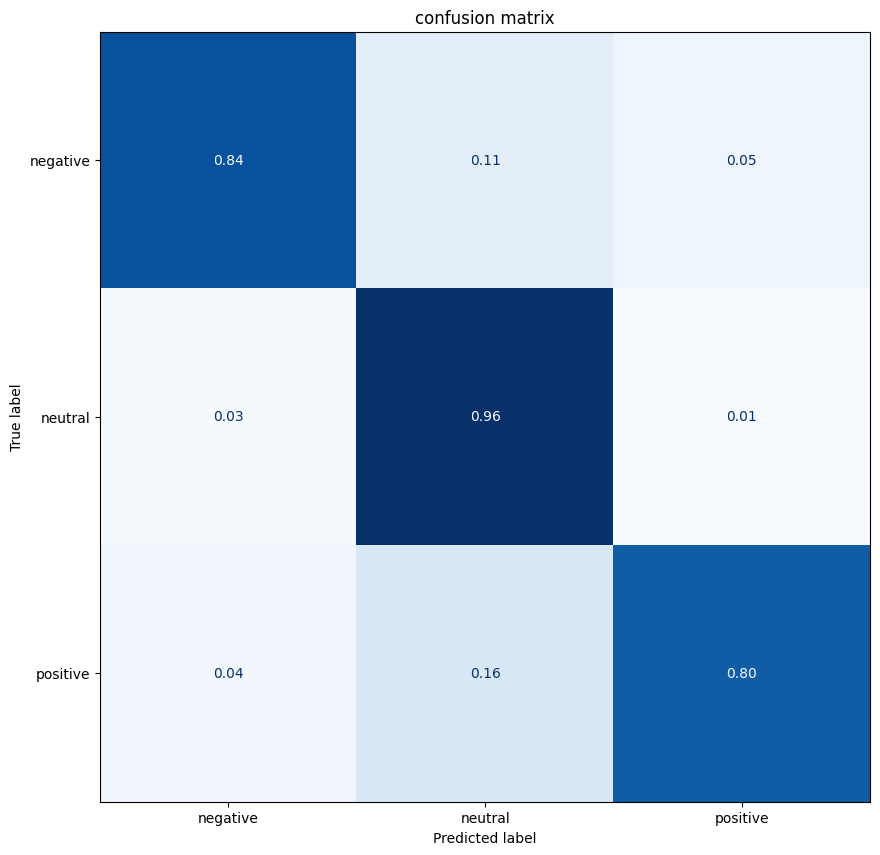

In [27]:
y_preds = np.argmax(preds_output.predictions, axis=1)
labels = train_dataset.features["label"].names
plot_confusion_matrix(y_preds, y_valid, labels)

In [28]:
trainer.save_model("./SA_results/my_model_balancedtrain_Sep12")

In [29]:
model.push_to_hub("my_model_ExperimentSA_balancedtrain_Sep12")
tokenizer.push_to_hub("my_model_ExperimentSA_balancedtrain_Sep12")

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/HFFErica/my_model_ExperimentSA_balancedtrain_Sep12/commit/75767913c2200b202d85cdd01acc5ec949300319', commit_message='Upload tokenizer', commit_description='', oid='75767913c2200b202d85cdd01acc5ec949300319', pr_url=None, pr_revision=None, pr_num=None)